In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import random


# import hyperparameters
from brnn_hyperparams import *
# from model import BRNN
from utils import load_dataset, get_num_class

import numpy as np

# processing bar
from tqdm import tqdm

# plots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{model_name}board_test')

### logging

In [10]:
import logging
logging.root.setLevel(logging.INFO)
# logging.basicConfig(level=logging.NOTSET)
logging.basicConfig(filename=log_name+'_test', 
                    filemode='a',
                    format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %P',
                    level=logging.INFO)

In [11]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.warning('Device: ' + device.type)
device

device(type='cuda')

## Utils

In [4]:
def load_dataset(fpath):
    '''
    params:
        fpath - path to fasta file, training or test
                ***The format of the sets:

                The first two lines are a global header:
                total_number_of_records
                input_size number_of_classes

                total_number_of_records is simply the number of proteins in the set,
                input_size is how many numbers are used to represent one amino acid (21
                or 22, probably, in your case) and number_of_classes is the number of
                classes...

                After that you have the proteins, 5 lines each:

                line 1: name of the protein
                line 2: number of amino acids in the protein
                line 3: input
                line 4: targets
                line 5: empty

                You can use any name you want so long as it's unique, a single word, and
                not outrageously long.

                The input should be a single long list of the numbers representing the
                amino acids in the protein. If you use, say, 21 numbers per amino acid,
                and the protein is 100 amino acids long, the input line will contain
                2100 numbers, with the first 21 being the representation of the first
                amino acid in the protein, the following 21 the representation of the
                second, etc.
                For the moment (before we use alignments) the representation of an amino
                acid will be a one-hot encoding, e.g.:

                A     -> 1 0 0 0 ..... 0 0
                C     -> 0 1 0 0 ..... 0 0
                ...
                Y     -> 0 0 0 0 ..... 1 0
                other -> 0 0 0 0 ..... 0 1

                where "other" is unknown or weird amino acid (X, B, J, O, U, Z)

                The line containing the targets is a list of integers representing the
                classes of the amino acids. There are as many integers as there are
                amino acids in the protein. You can choose whatever integers you want,
                but it's probably simplest to have something like class1=0, class2=1,
                class3=2, etc..

                (notice that in the sample sets in the directory you have a more
                complicated representation of the inputs, where there are a lot of
                floating point numbers rather than just 0 and 1, and that's because
                those inputs are frequency profiles from MSA - so you can see how the
                code works for both kinds of inputs)
                
    returns:
        p_data - list[data_tensor, target_tensor]
        p_lens - list, protein length
    
    Note: 
        - the reason not using tensor to save protein Sequences and Targets is we have varying length sequences! 
        - solve this problem we could consider pading. But our dataset lens range from about 20 to 10,000. 
            Thus, padding maybe not a good idea here.
    '''
    num_protein = 0
    num_i = 0
    num_o = 0

    # p_names = []
    p_lens = []
    # p_seqs = []
    # p_anns = []
    p_data = []
    with open(fpath) as fp:
        num_protein = int(fp.readline())
        num_io = fp.readline().split(' ')
        num_i = int(num_io[0])
        num_o = int(num_io[0])

        line = fp.readline()
        while line:
            # p_name = line[:-1]
            p_len = int(fp.readline())
            p_sequence = torch.tensor([int(x) for x in fp.readline().split(' ')], 
                                      dtype=torch.float32).reshape(-1, 21)
            p_annotation = torch.tensor([int(x) for x in fp.readline().split(' ')], dtype=torch.float32)
            # skip empty
            next(fp)
            # p_names.append(p_name)
            p_lens.append(p_len)
            # p_seqs.append(p_sequence)
            # p_anns.append(p_annotation)
            p_data.append([p_sequence, p_annotation])
            line = fp.readline()    
    return p_data, p_lens


In [5]:
def get_num_class(input_data):
    '''
    params:
        input_data - p_data format return from load_dataset function.
        
    returns:
        c0 - the number of amino acids of class 0, which means ordered.
        c1 - the number of amino acids of class 1, which means disordered.
    '''
    c0 = 0
    c1 = 0
    for batch_idx, (data, target) in enumerate(input_data):
        c0 = c0 + len(target) - target.sum()
        c1 = c1 + target.sum()
    return c0, c1


In [6]:
def rocPlot(train_label, train_probs, val_label, val_probs):
    fig = plt.figure(figsize=(12, 6))
    fpr, tpr, thresholds = roc_curve(train_label, train_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Training")
    plt.legend(loc="lower right")

    fpr, tpr, thresholds = roc_curve(val_label, val_probs)

    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=model_name+" ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Validation")
    plt.legend(loc="lower right")
    plt.show()
    return fig

## Dataset

In [7]:
#####
# 1. Dataset
#####

# Load training and test dataset
logging.warning('Loading training file ...')
train_data, train_plens = load_dataset(train_fpath)
logging.warning('Loading test file ...')
test_data, test_plens = load_dataset(test_fpath)

# Number of training and test dataset
n_train = len(train_data)
n_test = len(test_data)
logging.warning('Training set: ' + str(n_train))
logging.warning('Test set:     ' + str(n_test))

train_c0, train_c1 = get_num_class(train_data)
test_c0, test_c1 = get_num_class(test_data)
logging.warning(f'train c0, c1: {train_c0}, {train_c1}')
logging.warning(f'test c0, c1: {test_c0}, {test_c1}')


In [8]:
train_data_ori = train_data.copy()
test_data_ori = test_data.copy()

train_data = train_data_ori[:15]
test_data = test_data_ori[:5]

## Model

In [68]:
# set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                         bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        print('h0: ', h0.size())
        print('c0: ', c0.size())
        # Forward Prop
        # out, (hn, cn) = self.lstm(x,  (h0, c0))
        # out, _ = self.lstm(x,  (h0, c0))
        out, (hn, cn) = self.lstm(x,  (h0, c0))
        print('out: ', out.size())
        print('hn: ', hn.size())
        print('cn: ', cn.size())
        # all training example, last hidden state, all 
        # it is not last hidden state, it is the last batch
        print('out.squeeze() ', out.squeeze().size())
        out = self.fc(out.squeeze())
        print('out final: ', out.size())
        out = self.sigmoid(out)
        return out
    
    def train_batch(self, train_data, optimizer, criterion, num_batch, n_train):
        # set training state to model
        self.to(device)
        self.train()
        with tqdm(total=num_batch, position=0) as progress_bar:
            for i in range(num_batch):
                # get current batch dataset
                bat_data = train_data[i*batch_size:min((i+1)*batch_size, n_train)]
                bat_loss = 0
                count = 0
                for batch_idx, (data, target) in enumerate(bat_data):
                    data = data.to(device)
                    target = target.to(device)
                    
                    print('data: ', data.reshape(1, data.shape[0], data.shape[1]).size())
                    print('target: ', target.size())
                    
                    # forward
                    scores = self(data.reshape(1, data.shape[0], data.shape[1]))
                    loss = criterion(scores.squeeze(-1), target)
                    print('scores: ', scores)
                    print('loss: ', loss)
                    # LOSS
                    bat_loss = bat_loss + loss
                    if i==num_batch-1 or count==batch_size-1:
                        print('bat_loss: ', bat_loss)
                        # backword
                        optimizer.zero_grad()
                        bat_loss.backward()
                        #gradient descent or adam step
                        optimizer.step()
                        progress_bar.update(1)
                    count += 1
                
    def val_batch(self, val_data, criterion): 
        # set evaluation state to the model
        self.to(device)
        self.eval()
        losses = []
        
        class_probs = []
        class_label = []
        
        # no gradient needed
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_data):
                data = data.to(device)
                target = target.to(device)
                # forward
                scores = self(data.reshape(1, data.shape[0], data.shape[1]))
                loss = criterion(scores.squeeze(-1), target)
                # ERROR
                losses.append(loss.cpu()) # loss for each batch
                # save for ploting curve
                class_probs.append(scores.squeeze(-1).cpu())
                class_label.append(target.cpu())
                
        # overall loss
        loss = np.mean(losses)
        return loss, class_probs, class_label

## Initialization

In [69]:
# init model
model = BRNN(input_size, hidden_size, num_layers, num_classes)
# propogation of two classes
dis_sum = 0 
for batch_idx, (data, target) in enumerate(train_data):
    dis_sum = dis_sum + target.sum()
class_weights = torch.tensor([dis_sum/sum(train_plens), 1-dis_sum/sum(train_plens)], dtype=torch.float)
logging.warning('class weights: ' + str(class_weights))

# Loss & Optimizer
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Training

  0%|                                                                       | 0/1650 [00:00<?, ?it/s]

data:  torch.Size([1, 57, 21])
target:  torch.Size([57])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 57, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([57, 48])
out final:  torch.Size([57, 1])
scores:  tensor([[0.5027],
        [0.5028],
        [0.5027],
        [0.5026],
        [0.5025],
        [0.5024],
        [0.5024],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5024],
        [0.5024],
        [0.5023],
        [0.5021],
        [0.5021],
        [0.5021],
        [0.5021],
        [0.5021],
        [0.5022],
        [0.5022],
        [0.5022],
        [0.5022],
        [0.5022],
        [0.5021],
        [0.5021],
        [0.5020],
        [0.5019],
        [0.5018],
        [0.5018],
        [0.5018],
        [0.5018],
        [0.5018],
        [0.5019],
        [0.5019],
        [0.5019],
        [0.5020],
        [0.5020],
    

out:  torch.Size([1, 770, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([770, 48])
out final:  torch.Size([770, 1])
scores:  tensor([[0.5027],
        [0.5027],
        [0.5026],
        [0.5024],
        [0.5023],
        [0.5022],
        [0.5021],
        [0.5021],
        [0.5021],
        [0.5021],
        [0.5021],
        [0.5020],
        [0.5020],
        [0.5020],
        [0.5021],
        [0.5021],
        [0.5022],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5022],
        [0.5021],
        [0.5019],
        [0.5018],
        [0.5017],
        [0.5017],
        [0.5017],
        [0.5017],
        [0.5018],
        [0.5019],
        [0.5020],
        [0.5021],
        [0.5022],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5023],
        [0.5022],
        [0.5022],
        [0.5022],
        [0.5023],
        [0.5023],
        [0.5022],
        [0.5022],
      

  0%|                                                               | 1/1650 [00:01<34:45,  1.26s/it]

data:  torch.Size([1, 817, 21])
target:  torch.Size([817])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 817, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([817, 48])
out final:  torch.Size([817, 1])
scores:  tensor([[0.4983],
        [0.4974],
        [0.4967],
        [0.4962],
        [0.4958],
        [0.4955],
        [0.4953],
        [0.4952],
        [0.4950],
        [0.4949],
        [0.4948],
        [0.4946],
        [0.4945],
        [0.4945],
        [0.4944],
        [0.4945],
        [0.4945],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4946],
        [0.4946],
        [0.4945],
        [0.4945],
        [0.4946],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4949],
        [0.4949],
        [0.4949],
        [0.4947],

  0%|                                                               | 1/1650 [00:01<42:58,  1.56s/it]

out:  torch.Size([1, 378, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([378, 48])
out final:  torch.Size([378, 1])
scores:  tensor([[0.4984],
        [0.4974],
        [0.4967],
        [0.4961],
        [0.4958],
        [0.4956],
        [0.4955],
        [0.4953],
        [0.4952],
        [0.4951],
        [0.4950],
        [0.4948],
        [0.4945],
        [0.4942],
        [0.4941],
        [0.4940],
        [0.4941],
        [0.4941],
        [0.4942],
        [0.4943],
        [0.4945],
        [0.4946],
        [0.4946],
        [0.4946],
        [0.4946],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4947],
        [0.4947],
        [0.4946],
        [0.4946],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4948],
        [0.4947],
        [0.4946],
        [0.4945],
        [0.4945],
        [0.4944],
        [0.4943],
        [0.4943],
        [0.4943],
      

out:  torch.Size([1, 2550, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([2550, 48])
out final:  torch.Size([2550, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 46, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([46, 48])
out final:  torch.Size([46, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 559, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([559, 48])
out final:  torch.Size([559, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 267, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([267, 48])
out final:  torch.Size([267, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 161, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([161, 48])
out final:  torch.Size([

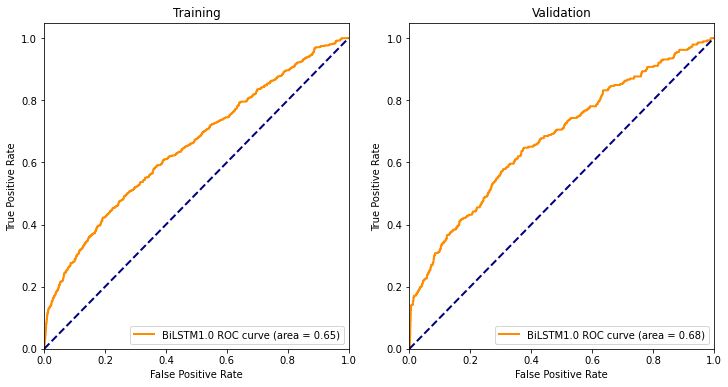

  0%|                                                                       | 0/1650 [00:00<?, ?it/s]

data:  torch.Size([1, 154, 21])
target:  torch.Size([154])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 154, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([154, 48])
out final:  torch.Size([154, 1])
scores:  tensor([[0.4984],
        [0.4974],
        [0.4965],
        [0.4959],
        [0.4955],
        [0.4952],
        [0.4949],
        [0.4947],
        [0.4946],
        [0.4945],
        [0.4944],
        [0.4943],
        [0.4943],
        [0.4944],
        [0.4945],
        [0.4945],
        [0.4945],
        [0.4945],
        [0.4945],
        [0.4945],
        [0.4945],
        [0.4944],
        [0.4943],
        [0.4943],
        [0.4943],
        [0.4944],
        [0.4945],
        [0.4946],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4946],
        [0.4946],
        [0.4946],
        [0.4945],
        [0.4944],
        [0.4944],
        [0.4944],
        [0.4944],

out final:  torch.Size([770, 1])
scores:  tensor([[0.4983],
        [0.4972],
        [0.4964],
        [0.4958],
        [0.4954],
        [0.4951],
        [0.4949],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4948],
        [0.4948],
        [0.4949],
        [0.4949],
        [0.4949],
        [0.4949],
        [0.4947],
        [0.4946],
        [0.4944],
        [0.4944],
        [0.4944],
        [0.4944],
        [0.4944],
        [0.4945],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4949],
        [0.4950],
        [0.4950],
        [0.4950],
        [0.4950],
        [0.4950],
        [0.4949],
        [0.4949],
        [0.4948],
        [0.4949],
        [0.4949],
        [0.4949],
        [0.4949],
        [0.4948],
        [0.4948],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4946],
        [0.4945],
        [0.4944],
    

out:  torch.Size([1, 817, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([817, 48])
out final:  torch.Size([817, 1])
scores:  tensor([[0.4983],
        [0.4974],
        [0.4967],
        [0.4962],
        [0.4958],
        [0.4955],
        [0.4953],
        [0.4952],
        [0.4950],
        [0.4949],
        [0.4948],
        [0.4946],
        [0.4945],
        [0.4945],
        [0.4944],
        [0.4945],
        [0.4945],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4948],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4947],
        [0.4946],
        [0.4946],
        [0.4945],
        [0.4945],
        [0.4946],
        [0.4946],
        [0.4947],
        [0.4948],
        [0.4949],
        [0.4949],
        [0.4949],
        [0.4947],
        [0.4946],
        [0.4946],
        [0.4945],
        [0.4945],
        [0.4945],
        [0.4945],
      

  0%|                                                               | 1/1650 [00:01<46:23,  1.69s/it]


data:  torch.Size([1, 161, 21])
target:  torch.Size([161])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 161, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([161, 48])
out final:  torch.Size([161, 1])
scores:  tensor([[0.4940],
        [0.4920],
        [0.4906],
        [0.4896],
        [0.4890],
        [0.4885],
        [0.4881],
        [0.4878],
        [0.4877],
        [0.4876],
        [0.4876],
        [0.4875],
        [0.4873],
        [0.4871],
        [0.4870],
        [0.4870],
        [0.4869],
        [0.4869],
        [0.4869],
        [0.4869],
        [0.4869],
        [0.4869],
        [0.4869],
        [0.4868],
        [0.4867],
        [0.4867],
        [0.4866],
        [0.4867],
        [0.4867],
        [0.4868],
        [0.4868],
        [0.4868],
        [0.4869],
        [0.4870],
        [0.4871],
        [0.4871],
        [0.4871],
        [0.4872],
        [0.4873],
        [0.4874],

out:  torch.Size([1, 2550, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([2550, 48])
out final:  torch.Size([2550, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 111, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([111, 48])
out final:  torch.Size([111, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 208, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([208, 48])
out final:  torch.Size([208, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 397, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([397, 48])
out final:  torch.Size([397, 1])
h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 770, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([770, 48])
out final:  torch.Siz

In [70]:
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate}")

num_batch = (n_train+batch_size-1)//batch_size
num_epochs = 2
scores = []
for epoch in range(num_epochs):
    logging.warning('*********************************')
    logging.warning('epoch: ' + str(epoch))
    logging.warning('*********************************')
    ################
    # 3.1. Training
    ################
    logging.warning('1. TRAINING:')
    # plot pr and roc curve or not
    plot_pr_roc = (epoch % plot_nEpoch == 0)
    
    random.shuffle(train_data)
    # training
    model.train_batch(train_data, optimizer, criterion, num_batch, n_train)
    
    # acc & loss
    train_loss, t_class_probs, t_class_label = model.val_batch(train_data, criterion)
    val_loss, v_class_probs, v_class_label = model.val_batch(test_data, criterion)
    
    # val_accs.append(val_acc)
    
    print('Training: Loss:')
    print(train_loss)
    
    print('VAL: Loss:')
    print(val_loss)
    
    logging.warning('Training:')
    logging.warning(f'Loss: {train_loss}')

    logging.warning('Validation:')
    logging.warning(f'Loss: {val_loss}')
    
    ##
    # for tensorboard plots
    ##
    writer.add_scalar("TRAIN: loss", train_loss, epoch)
    #writer.add_scalar("TRAIN: acc", train_acc, epoch)
    
    writer.add_scalar("VAL: loss", val_loss, epoch)
    #writer.add_scalar("VAL: acc", val_acc, epoch)
    
    ##
    # PR-curve & ROC-curve
    ##
    if plot_pr_roc:
        train_probs = torch.cat([batch for batch in t_class_probs])
        train_label = torch.cat(t_class_label)

        writer.add_pr_curve(f'TRAIN: pr_curve e{epoch}', train_label, train_probs, 0)

        val_probs = torch.cat([batch for batch in v_class_probs])
        val_label = torch.cat(v_class_label)

        writer.add_pr_curve(f'VAL: pr_curve e{epoch}', val_label, val_probs, 0)

        roc_fig = rocPlot(train_label, train_probs, val_label, val_probs)
        writer.add_figure(f'Train vs VAL: roc_curve e{epoch}', roc_fig)
    ##
    # Save model every m epochs
    ##
    if epoch % checkpoint_m == 0:
        cPATH = f"checkpoint/{model_name}_{epoch}.pth"
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss,
                    }, cPATH)
        
logging.warning(f"model_name: {model_name} \n \
                batch_size: {batch_size} \n \
                num_epochs: {num_epochs} \n \
                learning_rate: {learning_rate} \n ")
                # best_val_epoch: {int(np.argmax(val_accs)+1)}") # the best val epoch

writer.flush()
writer.close()

In [64]:
from torchinfo import summary

seq_len = 2000
summary(model, input_size=(1, seq_len, 21))

h0:  torch.Size([8, 1, 24])
c0:  torch.Size([8, 1, 24])
out:  torch.Size([1, 2000, 48])
hn:  torch.Size([8, 1, 24])
cn:  torch.Size([8, 1, 24])
out.squeeze()  torch.Size([2000, 48])
out final:  torch.Size([2000, 1])


Layer (type:depth-idx)                   Output Shape              Param #
BRNN                                     [2000, 1]                 --
├─LSTM: 1-1                              [1, 2000, 48]             51,648
├─Linear: 1-2                            [2000, 1]                 49
├─Sigmoid: 1-3                           [2000, 1]                 --
Total params: 51,697
Trainable params: 51,697
Non-trainable params: 0
Total mult-adds (M): 103.39
Input size (MB): 0.17
Forward/backward pass size (MB): 0.78
Params size (MB): 0.21
Estimated Total Size (MB): 1.16

In [65]:
print(model)

BRNN(
  (lstm): LSTM(21, 24, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [66]:
data.size()

torch.Size([580, 21])

In [56]:
data.reshape(1, data.shape[0], data.shape[1]).sum(axis=0).sum(axis=1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [71]:
target

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 